In [146]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [147]:
model_params = {
    'reaction_speed': 10, # the size of step of signal in binary model
    'max_reward': 200, # maximum reward for iteration
    'angle_loss_coeff': 1e3, #300000 # coef before punish for dismiss an angle
    'over_force_loss_coeff': 0, # coef before punish for inapropriate force (signals out of range [800, 2300])
    'upper_force_loss_coeff': 10., #3 # coef before punish for missing total force on y-axis. target_force is a target.
    'step_size': 1e-3, # time length of iteration in seconds
    'target_upper_force': 2.0, # total force on y-axis which wanted to be achieved and stated.
    'gamma': 0.99, # discount factor
}

False


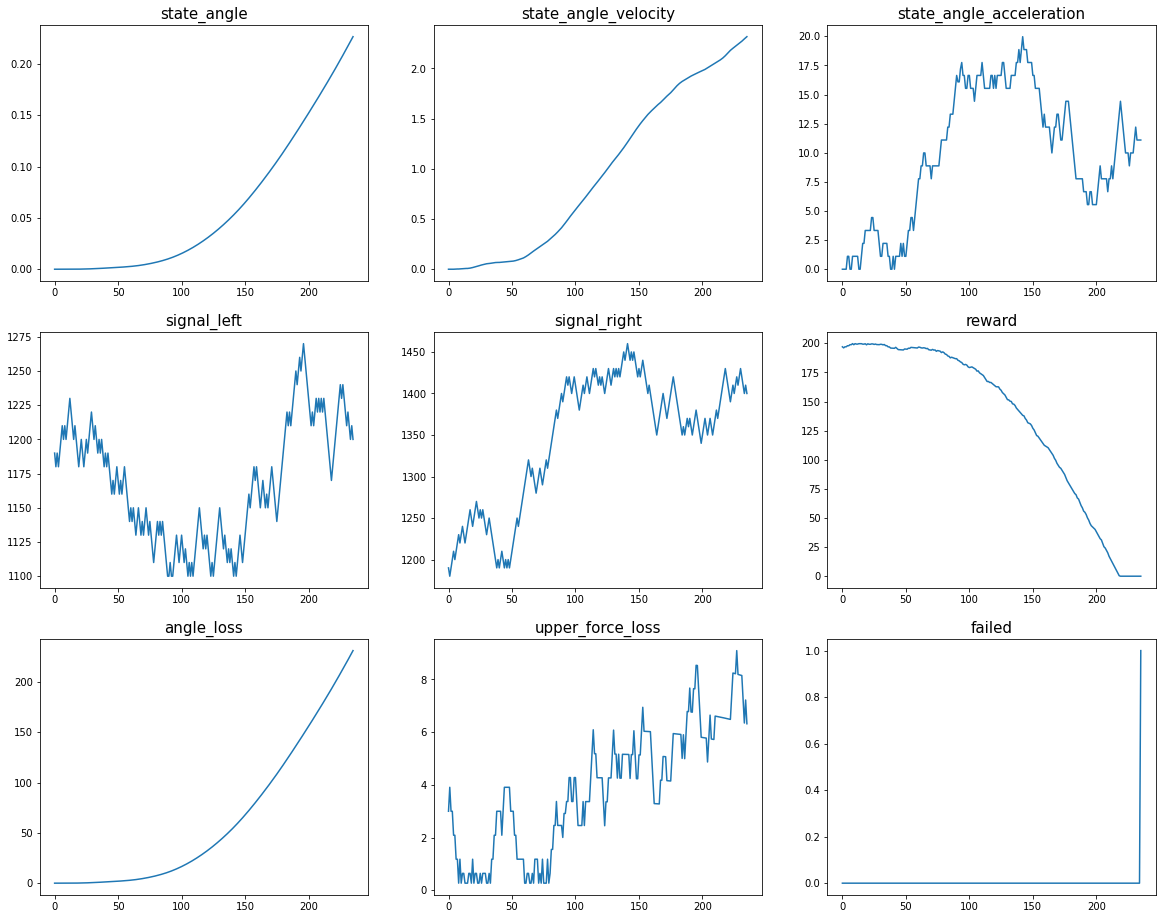

In [149]:
import matplotlib.pyplot as plt
from Copter.Session import Session
from Copter.Network import Network, FakeNet
net = FakeNet(5, 4)
s = Session(network=net, **model_params)
s.run(1000)
print(s.success)
# s.logs
s.plot_logs()


In [164]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import numpy as np
from utils import to_one_hot, normalize_tensor
from typing import Tuple, Type, Dict

class Trainer(object):
    def __init__(self, train_steps=10, n_iters=2000, n_sessions=50, percentile=70):
        self.network = Network(5, 4)
        self.session = Session(network=self.network, **model_params)

        # self.train_steps = train_steps
        self.n_iters = n_iters
        self.n_sessions = n_sessions
        self.percentile = percentile

        self.optimizer = torch.optim.Adam(self.network.parameters(), 1e-3)
        self.entropy_coef = 0.01 # for loss functions

        self.train_rewards = []
        self.train_elite_rewards = []
        self.train_losses = []
        self.info = []

    def generate_elites(self) -> Tuple[torch.Tensor, Tuple[torch.Tensor], Tuple[float]]:
        '''
        Generates `n_session` sessions then choose just `percentile` best of them by total reward.
        Returns 
        -state_tensor, 
        -actions_tensors, 
        -avg_rewards, 
        -info (for debug)
        which correspond to states and actions of concatenation of the best sessions.
        '''
        total_rewards = []
        session_lenghts = []
        state_tensors = []
        action_tensors_left = []
        action_tensors_right = []
        session_logs = []
        for _ in range(self.n_sessions):
            self.session.run(n_iters=self.n_iters, reset=True)
            total_rewards.append(self.session.total_reward)
            state_tensors.append(self.session.get_state_tensor())
            action_tensor_left, action_tensor_right = self.session.get_action_tensors() 
            action_tensors_left.append(action_tensor_left)
            action_tensors_right.append(action_tensor_right)
            session_lenghts.append(self.session.iteration)
            session_logs.append(self.session.logs.copy())
            # print(session_tensors[-1].shape)
        self.session.reset()

        reward_threshold = np.percentile(total_rewards, self.percentile)        
        elite_states = torch.vstack([state_tensors[i] for i in range(self.n_sessions) if reward_threshold <= total_rewards[i]])
        elite_actions_left = torch.vstack([action_tensors_left[i] for i in range(self.n_sessions) if reward_threshold <= total_rewards[i]])
        elite_actions_right = torch.vstack([action_tensors_right[i] for i in range(self.n_sessions) if reward_threshold <= total_rewards[i]])

        avg_session_reward = np.mean(total_rewards)
        avg_elite_session_reward = np.mean([reward for reward in total_rewards if reward_threshold <= reward])

        info = {
            # 'total_rewards': total_rewards,
            # 'elite_rewards': [reward for reward in total_rewards if reward_threshold <= reward],
            'lenghts': session_lenghts,
            'threshold': reward_threshold,
            # 'log': session_logs,
        }

        return elite_states, (elite_actions_left, elite_actions_right), (avg_session_reward, avg_elite_session_reward), info
    
    def train_model_step(self):
        '''
        Makes a step of CEM algorithm
        '''
        states_tensor, actions_tensor, avg_rewards, info = self.generate_elites()
        actions_left_tensor, actions_right_tensor = actions_tensor
        avg_session_reward, avg_elite_session_reward = avg_rewards

        logits = self.network(normalize_tensor(states_tensor))
        left_log_logits = F.log_softmax(logits[:, :2], -1)
        right_log_logits = F.log_softmax(logits[:, 2:], -1)
        log_probs_for_actions = torch.sum(left_log_logits * actions_left_tensor + right_log_logits * actions_right_tensor, dim=1) 
        
        # entropy = (torch.exp(log_probs_for_actions) * log_probs_for_actions).sum()
        loss = -log_probs_for_actions.mean() #- entropy * self.entropy_coef

        # log_prob = get_log_prob(actions_tensor, preds, self.model.std)
        # loss = -(log_prob * cumulative_rewards_tensor).mean()
        self.train_losses.append(loss.item())
        self.train_rewards.append(avg_session_reward)
        self.train_elite_rewards.append(avg_elite_session_reward)
        self.info.append(info)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def train_model(self, train_steps=10, print_=True):
        '''
        Trains model for several steps.
        '''
        for step in range(train_steps):
            self.train_model_step()
            if print_:
                print(step)

    def plot_trained_logs(self, window_size=10):
        # r = np.convolve(self.train_rewards, np.ones(window_size), 'valid') / window_size
        # elite_r = np.convolve(self.train_elite_rewards, np.ones(window_size), 'valid') / window_size
        plt.xlabel('step')
        plt.ylabel('reward')
        # plt.title('rolling reward')
        plt.plot(self.train_elite_rewards, label='elite')
        # plt.show()
        # plt.xlabel('step')
        # plt.ylabel('iterations')
        # plt.title('rolling num of iterations')
        plt.plot(self.train_rewards, 'all')
        plt.legend()
        plt.show()


0
1
2
3
4
5
6
7
8
9


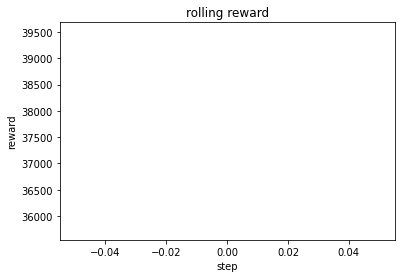

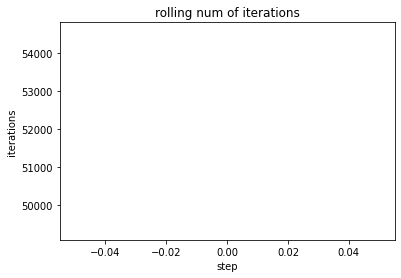

In [165]:
tr = Trainer(n_iters=2000, n_sessions=50, percentile=70)
tr.train_model(10)
tr.plot_trained_logs()
# tr.generate_sessions(100, 0.7).shape
# torch.vstack(t).shape

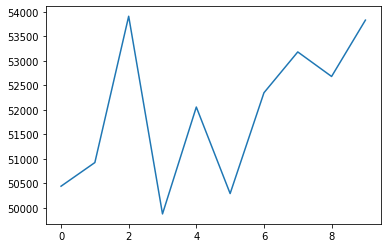

In [167]:
plt.plot(tr.train_elite_rewards)

{'state_angle': [],
 'state_angle_velocity': [],
 'state_angle_acceleration': [],
 'signal_left': [],
 'signal_right': [],
 'reward': [],
 'angle_loss': [],
 'upper_force_loss': [],
 'failed': [],
 'action_left': [],
 'action_right': [],
 'network_out_signal': [],
 'info': []}

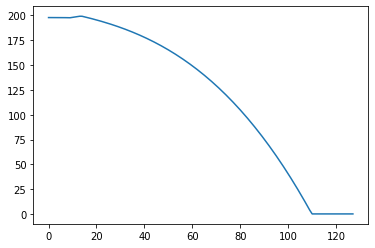

In [86]:
# np.mean(tr.train_elite_rewards), np.mean(tr.train_rewards)
# print(len(tr.train_rewards[0]), len(tr.train_elite_rewards[0]))
# plt.plot(tr.train_rewards[0])
# plt.show();
# plt.plot(tr.train_elite_rewards[0])
# plt.show();
plt.plot(tr.info[0]['log'][0]['reward'])
plt.plot(tr.info[0]['log'][1]['reward'])
plt.plot(tr.info[0]['log'][2]['reward'])

dict_keys(['state_angle', 'state_angle_velocity', 'state_angle_acceleration', 'signal_left', 'signal_right', 'reward', 'angle_loss', 'upper_force_loss', 'failed', 'action_left', 'action_right', 'network_out_signal', 'info'])

In [56]:
print(np.percentile(tr.train_rewards[0], 80))
np.sort(tr.train_rewards[0])

377583.367586087


array([374155.79498889, 375433.4091182 , 375730.06681309, 375954.57359811,
       375983.85899655, 376150.74805042, 376181.04160297, 376198.15946208,
       376218.27615503, 376238.87843301, 376413.47453421, 376442.35698903,
       376467.27514603, 376495.64362872, 376549.38607221, 376579.09404872,
       376597.95744683, 376611.16114874, 376621.69149093, 376670.73771844,
       376671.09444742, 376712.25808176, 376863.60942759, 376936.8107054 ,
       376968.73028086, 376970.88710885, 377001.17828256, 377027.03846909,
       377031.43888387, 377051.82131222, 377110.95353732, 377125.07401776,
       377252.67555392, 377294.97478599, 377312.27896633, 377373.16707128,
       377381.34197083, 377398.57367382, 377404.61335692, 377581.24931124,
       377591.84068547, 377603.0875524 , 377606.39855926, 377672.93199999,
       377672.93199999, 377672.93199999, 377672.93199999, 377672.93199999,
       377672.93199999, 377672.93199999])

In [237]:
reward_threshold = np.percentile(r, 0.7)
# [t[i] for i in range(10) if reward_threshold <= r[i]]

In [4]:
net = Network(3, 4)
s = Session(net, **model_params)

In [28]:
# s.model.compute_angle_acceleration(6.) * 0.1
from utils import signal_to_force, compute_total_J
from model_parameters import MOTOR_DISTANCE, MAX_ANGLE
# signal_to_force(2300)
# j = compute_total_J(True)
(s.model.compute_angle_acceleration(6) * MAX_ANGLE * 0.9 / 180 * 3.1415 * 2)**0.5 * 180 / 3.1415

330.7851343621104

In [15]:
s.train_model(10, 1000, False)

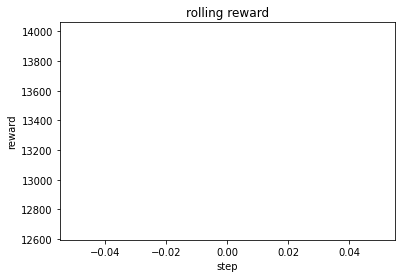

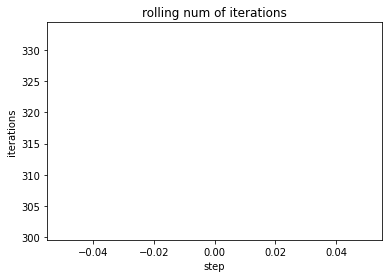

In [16]:
s.plot_trained_logs(window_size=10)

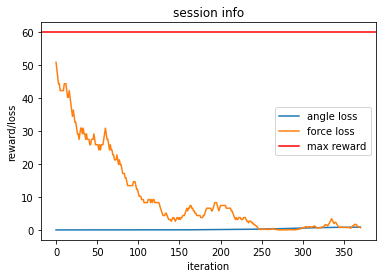

In [17]:
s.plot_info()

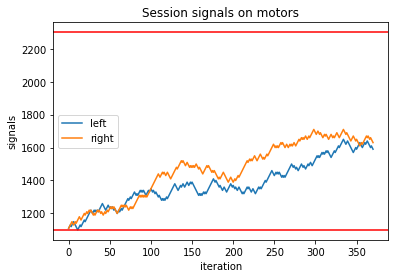

In [18]:
s.plot_signals()

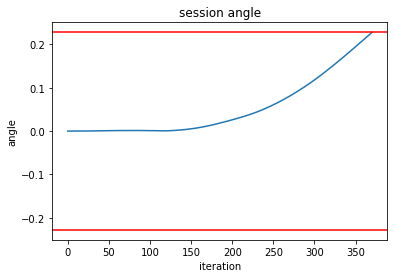

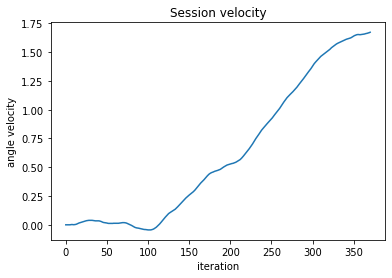

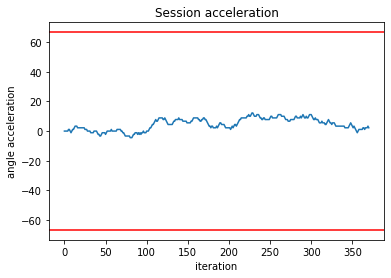

In [19]:
s.plot_states()

In [332]:
s.plot_actions()

AttributeError: 'Session' object has no attribute 'plot_actions'

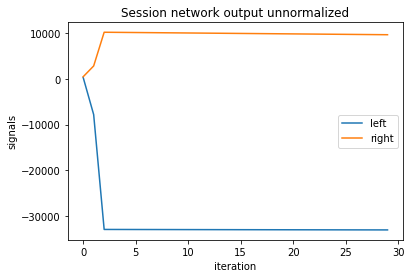

In [145]:
s.plot_signals()

In [14]:
from utils import compute_total_J
compute_total_J(False)

21.8


12956637.786666665

In [63]:
from Copter.Session import Session
s = Session()
s.run(10)

d:\STUDY\code\ML notebooks\my\copter\Copter\TwoMotorStick.py:34: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probas = F.softmax(logits).numpy()


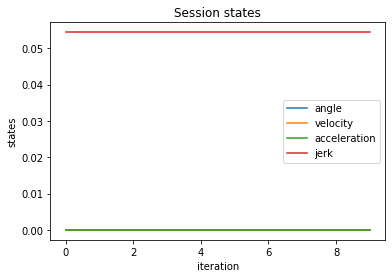

In [64]:
s.plot_states()

In [1]:
# all parameters in mm's and gramms

# STICK_LENGTH = 370.
# STICK_HEIGHT = 59.
# STICK_MASS = 196.

# MOTOR_MASS = 67.
# MOTOR_DISTANCE = 158.
# MOTOR_HEIGHT = 50.

# REGULATOR_MASS = 24.
# REGULATOR_DISTANCE = 70.
# REGULATOR_HEIGHT = 32.

# CENTER_AXIS_IDENT = 17.5
# PILLAR_HEIGH = 0
from model_parameters import *
2 * (MOTOR_MASS * MOTOR_HEIGHT + REGULATOR_MASS * REGULATOR_HEIGHT) \
    / (2 * MOTOR_MASS + 2 * REGULATOR_MASS + STICK_MASS)

21.788359788359788

In [1]:
import torch

In [10]:
a = torch.tensor([1, 2, 3])
b = torch.tensor([4, 5, 6])
c = torch.vstack([a, b])
torch.square(c)

tensor([[ 1,  4,  9],
        [16, 25, 36]])

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch


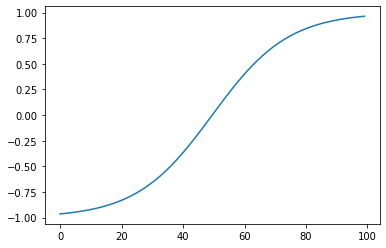

In [22]:
space = np.linspace(-2, 2, 100)
ans = []
for a in space:
    ans.append(torch.tanh(torch.tensor(a)).item())
plt.plot(ans)

In [44]:
import math
mean = 1
var = 1

In [45]:
np.random.normal(mean, var)

1.3196001152839887

In [46]:
a = np.array([1, 3])
a.tolist()

[1, 3]

In [153]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [167]:
df = pd.read_csv('Motor force detection.csv')

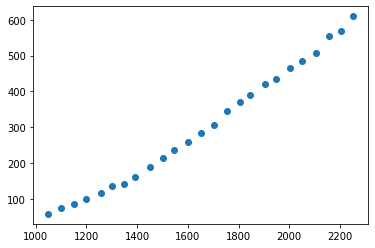

In [168]:
plt.scatter(x=df.input, y=df.mass)

In [169]:
lr = LinearRegression()
lr.fit(df.drop('mass', axis=1), df.mass)

LinearRegression()

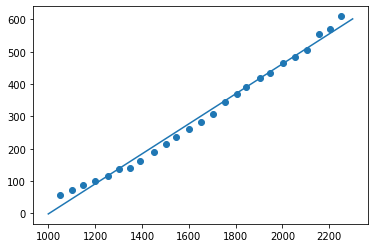

In [170]:
space = np.linspace(1000, 2300)
preds = lr.intercept_ + lr.coef_[0] * space
plt.plot(space, preds)
plt.scatter(x=df.input, y=df.mass)
plt.show()

In [171]:
np.array([lr.intercept_, lr.coef_[0]]) * 1e-3 * 9.8

array([-4.56204418e+00,  4.54791687e-03])

In [172]:
lr.predict(np.array([[2300]]))

array([601.85353414])

In [173]:
np.random.choice(2, 1, p=np.array([0.3, 0.7]))[0]

[autoreload of Copter.TwoMotorStick failed: Traceback (most recent call last):
  File "C:\Users\Danill\AppData\Local\Programs\Python\Python37\lib\site-packages\IPython\extensions\autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "C:\Users\Danill\AppData\Local\Programs\Python\Python37\lib\site-packages\IPython\extensions\autoreload.py", line 394, in superreload
    module = reload(module)
  File "C:\Users\Danill\AppData\Local\Programs\Python\Python37\lib\imp.py", line 314, in reload
    return importlib.reload(module)
  File "C:\Users\Danill\AppData\Local\Programs\Python\Python37\lib\importlib\__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 630, in _exec
  File "<frozen importlib._bootstrap_external>", line 728, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "d:\STUDY\code\ML notebooks\my\copter\Copter\TwoMotorStick.py", line 4, in 

1

In [192]:
a = torch.rand(4,4)
a

tensor([[0.1376, 0.8149, 0.3219, 0.1905],
        [0.3193, 0.3232, 0.3588, 0.0897],
        [0.7505, 0.8373, 0.6066, 0.6727],
        [0.3603, 0.9797, 0.6747, 0.3969]])

In [193]:
a[:, :2]

tensor([[0.1376, 0.8149],
        [0.3193, 0.3232],
        [0.7505, 0.8373],
        [0.3603, 0.9797]])